In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *
from Shared.specific_CNB_decay import *

sim_name = f"no_gravity"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
Delta_folder = f"Shared/Deltas"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

In [3]:
gammas =['0.1T','0.5T','T','2T']

tot_dens_l_d =[]
tot_dens_l_p =[]
tot_dens_l_nd =[]
nu_m_range_2= np.array([0.06])
nu_m_range= np.array([0.05])

for gamma in gammas:
    nu_vectors_d = jnp.load(f"{sim_folder}/vectors_halo1_d_{gamma}.npy")
    nu_vectors_p = jnp.load(f"{sim_folder}/vectors_halo1_p_{gamma}.npy")
    nu_vectors_nd = jnp.load(f"{sim_folder}/vectors_halo1.npy")
    
    tot_dens_d = decay.number_densities_mass_range_decay(
        v_arr=nu_vectors_d.reshape(-1, 2, 6)[..., 3:], 
        m_arr=nu_m_range, 
        pix_sr=4*Params.Pi,
        args=Params())
    
  
    tot_dens_nd = decay.number_densities_mass_range_decay(
        v_arr=nu_vectors_nd.reshape(-1, 2, 6)[..., 3:], 
        m_arr=nu_m_range_2, 
        pix_sr=4*Params.Pi,
        args=Params())
    tot_dens_p = tot_dens_nd-tot_dens_d

    tot_dens_l_nd.append((tot_dens_nd))
    tot_dens_l_d.append(tot_dens_d)
    tot_dens_l_p.append((tot_dens_p))
    


In [4]:
print((tot_dens_l_d))

[Array([56.60912109], dtype=float64), Array([56.60912109], dtype=float64), Array([56.60912109], dtype=float64), Array([56.60912109], dtype=float64)]


In [ ]:
halos =['halo1','halo2','halo3','halo4','halo5','halo6','halo7','halo8','halo9','halo10']
pix_dens_l_d =[]
pix_dens_l_p =[]
pix_dens_l_nd =[]
nu_m_range_2= np.array([0.06])
nu_m_range= np.array([0.05])
decay.number_densities_all_sky(
    v_arr=nu_vectors_d[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())

for halo in halos:
    nu_vectors_d = jnp.load(f"sim_output/Dopri5_1k/vectors_{halo}_d_{gamma}.npy")
    nu_vectors_p = jnp.load(f"sim_output/Dopri5_1k/vectors_{halo}_p_{gamma}.npy")
    nu_vectors_nd = jnp.load(f"sim_output/Dopri5_1k/vectors_{halo}.npy")
    
    tot_dens_d_pix = decay.number_densities_mass_range_decay(
            v_arr=nu_vectors_d[..., 3:],
            m_arr=nu_m_range,
            pix_sr=simdata.pix_sr,
            args=Params())

    tot_dens_nd_pix = decay.number_densities_mass_range_decay(
        v_arr=nu_vectors_nd[..., 3:],
        m_arr=nu_m_range,
        pix_sr=simdata.pix_sr,
        args=Params())


    
    pix_dens_l_nd.append((tot_dens_nd_pix))
    pix_dens_l_d.append((tot_dens_d_pix))
    tot_dens_p_pix = tot_dens_nd-tot_dens_d
    pix_dens_l_p.append((tot_dens_p_pix))


[Array([56.60912109], dtype=float64), Array([56.60912109], dtype=float64), Array([56.60912109], dtype=float64), Array([56.60912109], dtype=float64)]
[0.99999999 0.99999999 0.99999999 0.99999999]


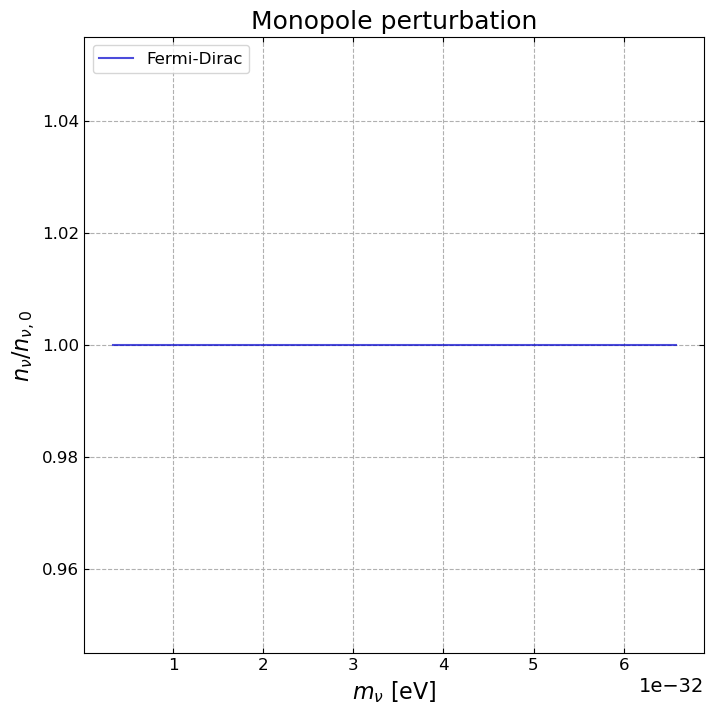

In [5]:
colors = ["mediumblue"]
labels = ["Fermi-Dirac"]
print(tot_dens_l_d)
fig_paths = [
    f"{fig_folder}/overdensity_band_{sim_name}_linear.pdf",
    f"{fig_folder}/overdensity_band_{sim_name}_linear.png"
]
number_densities_monopole_d = np.array(tot_dens_l_d).reshape(1,4)

eta = 5*1e-1
gammas = np.array([(1/0.1)*10**(-17)/s,(1/0.5)*10**(-17)/s,(1/1)*10**(-17)/s,(1/2)*10**(-17)/s])
SimPlot.overdensity_band_decay(
    dens_FD=np.array(number_densities_monopole_d),
    m_arr_FD=gammas,
    colors=colors,
    labels=labels,
    plot_xlims=None,
    plot_ylims=None,
    plot_log=False,
    fig_paths=fig_paths,
    args=Params())

In [17]:
m_pick =0.05
pix_dens_FD= np.array( pix_dens_l_d)
def power_spectra_FDxPF_decay(
    m_pick, pix_dens_FD, y_lims, sim_dir, fig_dir, args):
    
    m_specs = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*args.eV
    m_range = jnp.load(f"{sim_dir}/neutrino_massrange_eV.npy")

    mPF_i = jnp.abs(m_specs - m_pick).argmin()
    # mFD_i = jnp.abs(m_range - m_pick).argmin()
    mFD_i = jnp.abs(m_specs - m_pick).argmin()

    halo_num = len(pix_dens_FD)

    power_spectra_FD_l = []
    for halo_i in range(halo_num):

        m_nu = m_specs[mFD_i]

        FD_skymap = pix_dens_FD[halo_i, mFD_i]

        # Convert maps of neutrino densities to temperatures.
        cm3 = args.cm**3
        FD_Tmap = np.cbrt((FD_skymap*(1/cm3)*4*args.Pi**2) / (args.g_nu*3*zeta(3)))

        T_unit = args.muK
        FD_Tmap /= T_unit

        # Compute power spectrum of number density all-sky map.
        cl_FD = hp.sphtfunc.anafast(FD_Tmap, lmax=None)

        ell = jnp.arange(len(cl_FD))

        # Unit to compare to similar figures in literature.
        # scaling = Primordial.Cl_scaling
        scaling = 1  # if Tmaps already in muK
        
        power_spectrum_FD = ell * (ell+1) * cl_FD * scaling / (2*args.Pi)

        power_spectra_FD_l.append(power_spectrum_FD)


    # Convert lists to arrays
    power_spectra_FD = jnp.array(power_spectra_FD_l)

    # Compute median and percentile ranges for Fermi-Dirac spectra
    power_median_FD = jnp.median(power_spectra_FD, axis=0)
    power_perc2p5_FD = jnp.percentile(power_spectra_FD, q=2.5, axis=0)
    power_perc97p5_FD = jnp.percentile(power_spectra_FD, q=97.5, axis=0)
    power_perc16_FD = jnp.percentile(power_spectra_FD, q=16, axis=0)
    power_perc84_FD = jnp.percentile(power_spectra_FD, q=84, axis=0)

    fig = plt.figure(figsize =(6, 4))
    fig.tight_layout()
    ax1 = fig.add_subplot(111)

    FD_color = "mediumblue"
    ax1.semilogy(
        ell, power_median_FD, color=FD_color, 
        label=r"$f_{\rm FD}$")
    # ax1.fill_between(
    #     ell, power_perc2p5_FD, power_perc97p5_FD, 
    #     color=FD_color, alpha=0.15, label='2.5-97.5 % C.L.')
    ax1.fill_between(
        ell, power_perc16_FD, power_perc84_FD, 
        color=FD_color, alpha=0.25, label='16-84 % C.L.')
    

    # ax1.set_title(fr"Power spectra comparison $m_\nu = ${m_pick} eV")
    ax1.set_xlabel("$\ell$")
    # ax1.set_xlim(1,np.max(ell))
    ax1.set_xlim(1,21)
    ax1.set_ylabel(r"$\ell(\ell+1)C_{\ell} \, / \, 2\pi \,\, [\mu K^2]$")

    if y_lims is not None:
        ax1.set_ylim(y_lims[0], y_lims[1])

    ax1.grid(True, which="major", linestyle="dashed")
    ax1.legend(loc='lower left', prop={'size':10})

    plt.savefig(
        f"{fig_dir}/power_spectra_FD_vs_PF_decay_{m_pick}eV.pdf", 
        bbox_inches="tight")
    plt.savefig(
        f"{fig_dir}/power_spectra_FD_vs_PF_decay_{m_pick}eV.png", 
        bbox_inches="tight")
    plt.show(); plt.close()


N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)
print(f"Input array must have shape (halos, masses, Npix). Here:", pix_dens_FD.shape)
for m_pick in nu_m_picks[2:3]:
    power_spectra_FDxPF_decay(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD - skymap_norm, 
        # y_lims=None,
        y_lims=(1e5, 1e11),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params())

Input array must have shape (halos, masses, Npix). Here: (10, 1, 768)


KeyboardInterrupt: 